In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, GRU, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd
import re
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
# Load the CSV dataset
df = pd.read_csv('fashion_store.csv')

# Check the column names (optional)
print(df.columns)

# Define a function to preprocess text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

# Apply preprocessing to 'question' and 'answer' columns
df['Question'] = df['Question'].apply(preprocess_text)
df['Answer'] = df['Answer'].apply(preprocess_text)

# Create separate lists for questions and answers
questions = df['Question'].tolist()
answers = df['Answer'].tolist()


Index(['Question', 'Answer'], dtype='object')


In [3]:
# Advanced Data Preprocessing
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(questions)  # Use 'questions' instead of 'dataset'
vocab_size = len(tokenizer.word_index) + 1

sequences = tokenizer.texts_to_sequences(questions)  # Use 'questions' here
input_sequences = [sequence[:-1] for sequence in sequences]
target_sequences = [sequence[1:] for sequence in sequences]

max_sequence_length = max(len(sequence) for sequence in input_sequences)
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='post')
target_sequences = pad_sequences(target_sequences, maxlen=max_sequence_length, padding='post')


In [4]:
# Advanced Data Preprocessing
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(answers)  # Use 'answers' instead of 'dataset'
vocab_size = len(tokenizer.word_index) + 1  # Make sure vocab_size is the same

sequences = tokenizer.texts_to_sequences(answers)  # Use 'answers' here
input_sequences = [sequence[:-1] for sequence in sequences]
target_sequences = [sequence[1:] for sequence in sequences]

max_sequence_length = max(len(sequence) for sequence in input_sequences)
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='post')
target_sequences = pad_sequences(target_sequences, maxlen=max_sequence_length, padding='post')


In [5]:
# Build the chatbot model with Bidirectional LSTM and GRU
embedding_dim = 100
hidden_units = 256

input_layer = Input(shape=(max_sequence_length,))
embedding_layer = Embedding(vocab_size, embedding_dim)(input_layer)
bidirectional_lstm = Bidirectional(LSTM(units=hidden_units, return_sequences=True))(embedding_layer)
gru_layer = GRU(units=hidden_units, return_sequences=True)(bidirectional_lstm)
output_layer = Dense(vocab_size, activation='softmax')(gru_layer)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [6]:
# Define a function to preprocess new input text
def preprocess_input_text(input_text):
    encoded_input = tokenizer.texts_to_sequences([input_text])[0]
    padded_input = pad_sequences([encoded_input], maxlen=max_sequence_length, padding='post')
    return padded_input

In [7]:
# Convert target_sequences to one-hot encoded format
target_sequences_one_hot = to_categorical(target_sequences, num_classes=vocab_size)


In [8]:

# Training the model (replace with your training data and hyperparameters)
num_epochs = 10
batch_size = 64

# Collect model training history for accuracy
history = model.fit(input_sequences, target_sequences_one_hot, epochs=num_epochs, batch_size=batch_size, validation_split=0.2)



Epoch 1/10
13/13 [==============================] - 9s 362ms/step - loss: 4.5144 - accuracy: 0.4087 - val_loss: 3.3148 - val_accuracy: 0.4418
Epoch 2/10
13/13 [==============================] - 4s 289ms/step - loss: 3.2347 - accuracy: 0.4418 - val_loss: 3.1439 - val_accuracy: 0.4427
Epoch 3/10
13/13 [==============================] - 4s 338ms/step - loss: 3.1092 - accuracy: 0.4419 - val_loss: 3.0720 - val_accuracy: 0.4418
Epoch 4/10
13/13 [==============================] - 4s 289ms/step - loss: 3.0549 - accuracy: 0.4419 - val_loss: 3.0279 - val_accuracy: 0.4436
Epoch 5/10
13/13 [==============================] - 4s 292ms/step - loss: 3.0025 - accuracy: 0.4464 - val_loss: 2.9488 - val_accuracy: 0.4591
Epoch 6/10
13/13 [==============================] - 4s 339ms/step - loss: 2.8885 - accuracy: 0.4675 - val_loss: 2.7959 - val_accuracy: 0.4755
Epoch 7/10
13/13 [==============================] - 4s 333ms/step - loss: 2.7393 - accuracy: 0.4773 - val_loss: 2.6544 - val_accuracy: 0.4727
Epoch 

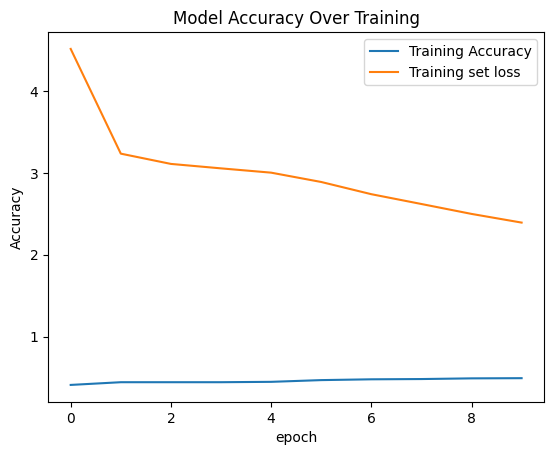

In [9]:
import matplotlib.pyplot as plt  # Add this import for plotting

# Plot training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['loss'], label='Training set loss')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy Over Training')
plt.show()

In [10]:
# Define a function to preprocess new input text
def preprocess_input_text(input_text):
    encoded_input = tokenizer.texts_to_sequences([input_text])[0]
    padded_input = pad_sequences([encoded_input], maxlen=max_sequence_length, padding='post')
    return padded_input

In [11]:
def generate_text_nucleus_sampling(seed_text, num_words, temperature=1.0, top_p=0.9):
    generated_text = seed_text
    for _ in range(num_words):
        encoded_seed = tokenizer.texts_to_sequences([seed_text])[0]
        padded_seed = pad_sequences([encoded_seed], maxlen=max_sequence_length, padding='post')
        predicted_probs = model.predict(padded_seed)[0]

        # Apply nucleus sampling
        sorted_indices = np.argsort(predicted_probs)[-1::-1]
        cumulative_probs = np.cumsum(predicted_probs[sorted_indices])
        cumulative_probs_threshold = cumulative_probs[int(0.9 * len(cumulative_probs))]
        selected_indices = sorted_indices[cumulative_probs <= cumulative_probs_threshold]

        if len(selected_indices) == 0:
            break  # To prevent an infinite loop if top_p is too small

        # Randomly select from the remaining candidates based on the temperature
        probabilities = predicted_probs[selected_indices] / temperature
        probabilities = probabilities / np.sum(probabilities)
        predicted_word_index = np.random.choice(selected_indices, p=probabilities)

        predicted_word = tokenizer.index_word[predicted_word_index]
        generated_text += " " + predicted_word
        seed_text = generated_text

    return generated_text


# Generate chatbot responses using nucleus sampling
seed_text = "Hello, how are you?"
num_words = 20
nucleus_response = generate_text_nucleus_sampling(seed_text, num_words, temperature=1, top_p=0.9)
print("Nucleus Sampling:", nucleus_response)


1/1 [==============================] - 1s 795ms/step


IndexError: ignored